In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# PEFT IMDB Imbalance + Noise

This experiment asks whether imbalance in datasets has an impact on robustness of transformer models

In [3]:
import glob
import re

LABEL = "sentiment"
BALANCE = 0.5
EPOCHS = 10
limit = 10000
l2 =0.01
method="lora"
root_dir = f"../experiments/acl-exp5-method-{method}-limit-{limit}-l2-{l2}-balance-{BALANCE}"
DATASET = f"IMDB-balance-{BALANCE}"

def get_pred_df(root_dir):


    dfs = []
    # for directory in root_dir:
    directory = root_dir
    
    seed = directory.split("-")[-1]
    exp0_subdirs = [f for f in os.listdir(directory)]
    exp0_subdirs
    

    # Use regex to extract the value after "sentiment-"

    # Check if there is a match

    for split in ["train", "val"]:
        for dir in exp0_subdirs:
            # print(dir)
            
            match = re.search(f'{LABEL}-noise-(\d+\.\d+)', dir)
            if match:
                noise_ratio = float(match.group(1))
                # print("Sentiment Value:", noise_ratio)
            else:
                print("No sentiment value found.")

            df = pd.read_csv(os.path.join(root_dir, dir, f"{split}_preds.csv"))
            df["noise_ratio"] = noise_ratio
            df["split"] = split
            df["seed"] = seed
            dfs.append(df)

    pred_df = pd.concat(dfs)
    return pred_df



# F1 Scores

In [4]:
from sklearn.metrics import f1_score,recall_score, precision_score

def get_f1_df(pred_df, epochs=20):

    epochs = []
    f1s = []
    noises = []
    splits = []
    for i in range(0, 20):
        for noise in [0.0, 0.1, 0.2, 0.3, 0.4]:
            for split in ["train", "val"]:
                epochs.append(i)
                noises.append(noise)
                splits.append(split)
                if i == 0:
                    f1s.append(0)
                else:
                    df = pred_df[pred_df["noise_ratio"] == noise]   
                    df = df[df["split"] == split]
                    f1 = f1_score(df["label"], df[f"pred_{i}"], average="binary")
                    f1s.append(f1)
                    # print("noise", noise, "split", split, "epoch", i, "f1", f1)
    
    data = {'epochs': epochs, 'f1s': f1s, "noise":noises, "split":splits}
    df = pd.DataFrame(data) 
    return df






Effect of Balance - Control Data Size

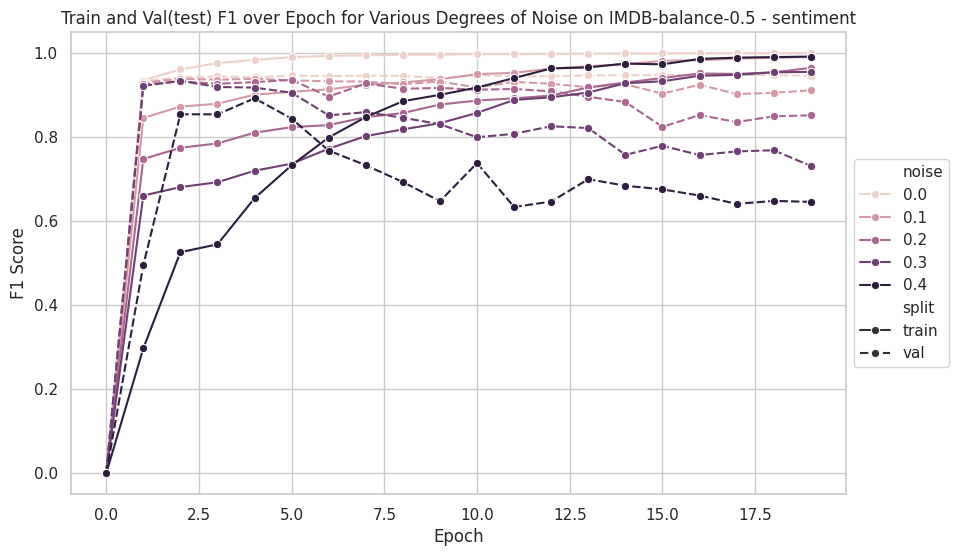

             epochs       f1s
noise split                  
0.0   train      19  0.999800
      val        19  0.948661
0.1   train      19  0.990570
      val        19  0.939194
0.2   train      19  0.965083
      val        19  0.936379
0.3   train      19  0.955461
      val        19  0.934224
0.4   train      19  0.991925
      val        19  0.892502


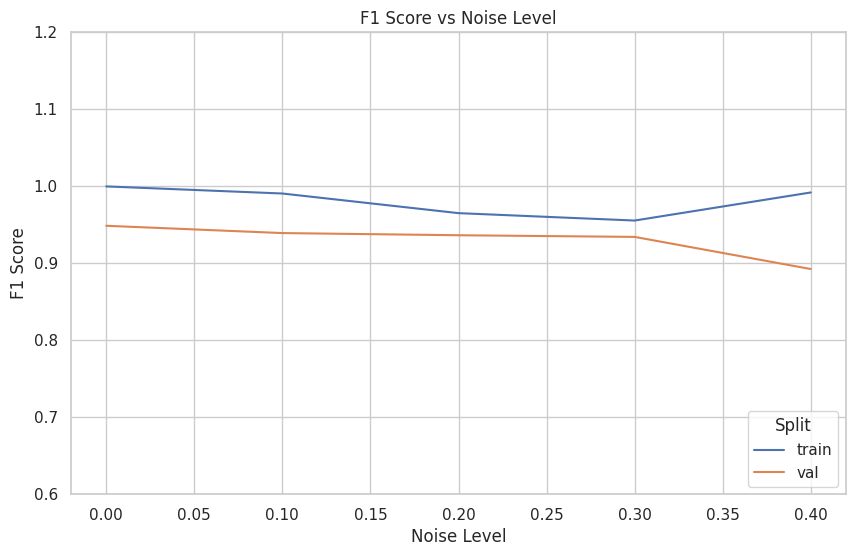

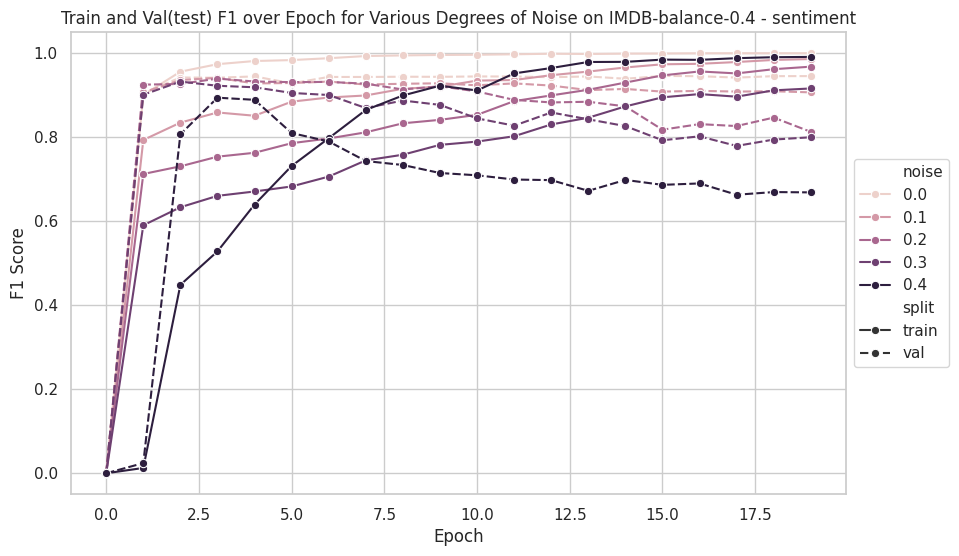

             epochs       f1s
noise split                  
0.0   train      19  0.999750
      val        19  0.945801
0.1   train      19  0.985953
      val        19  0.941148
0.2   train      19  0.967809
      val        19  0.939379
0.3   train      19  0.915961
      val        19  0.932320
0.4   train      19  0.991059
      val        19  0.893971


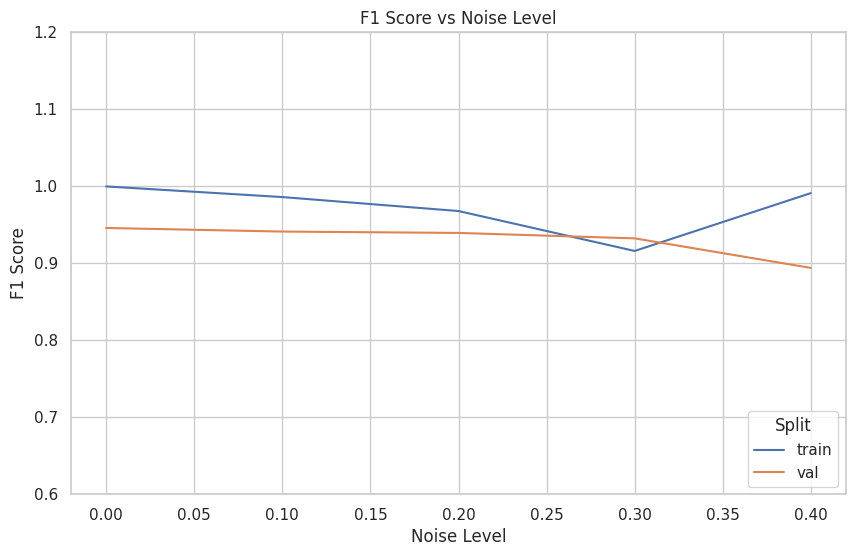

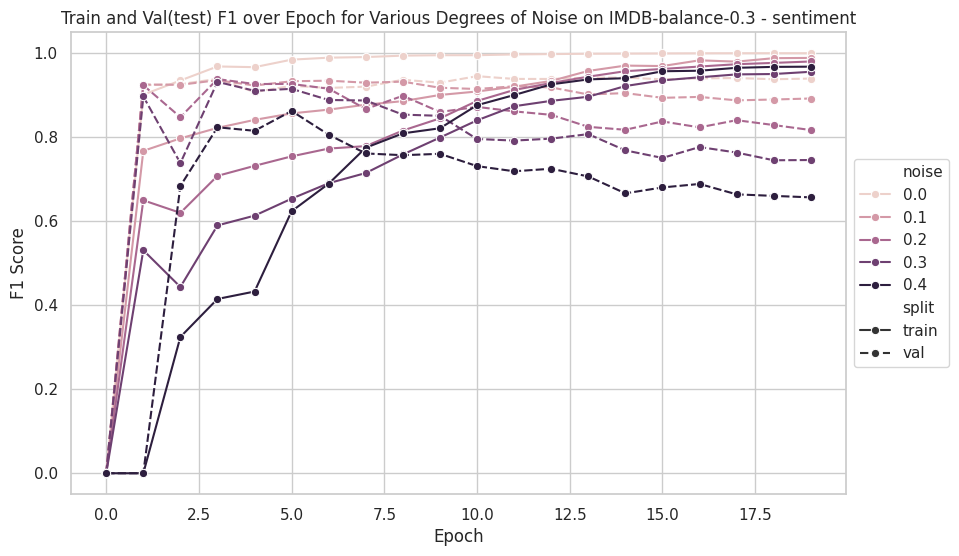

             epochs       f1s
noise split                  
0.0   train      19  0.999833
      val        19  0.945249
0.1   train      19  0.988751
      val        19  0.935766
0.2   train      19  0.980241
      val        19  0.938361
0.3   train      19  0.955720
      val        19  0.931745
0.4   train      19  0.967862
      val        19  0.862381


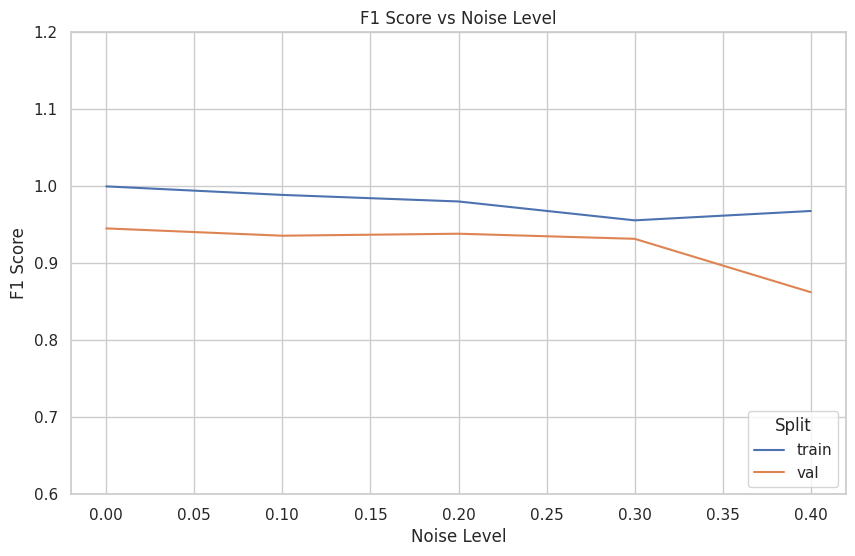

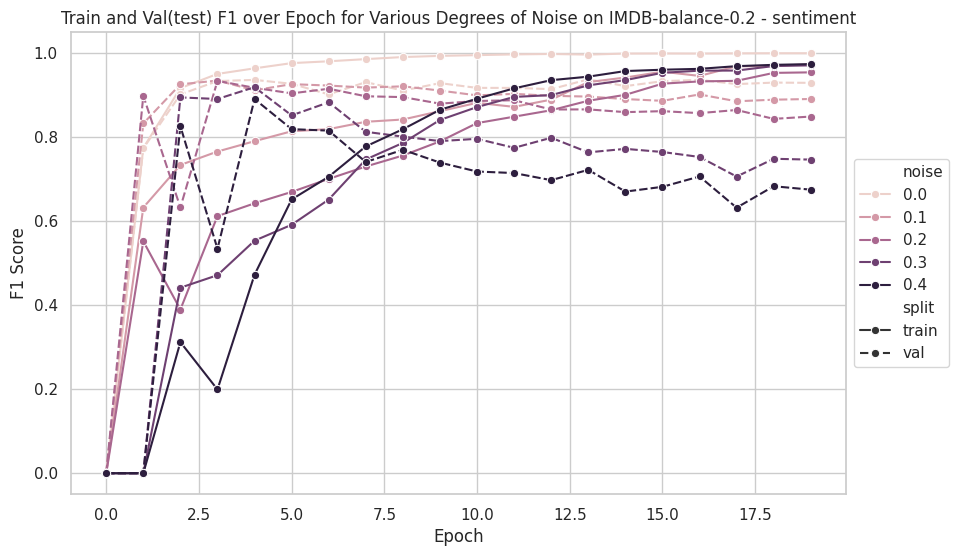

             epochs       f1s
noise split                  
0.0   train      19  0.999000
      val        19  0.936910
0.1   train      19  0.972877
      val        19  0.934003
0.2   train      19  0.953574
      val        19  0.933301
0.3   train      19  0.970196
      val        19  0.918282
0.4   train      19  0.973161
      val        19  0.890047


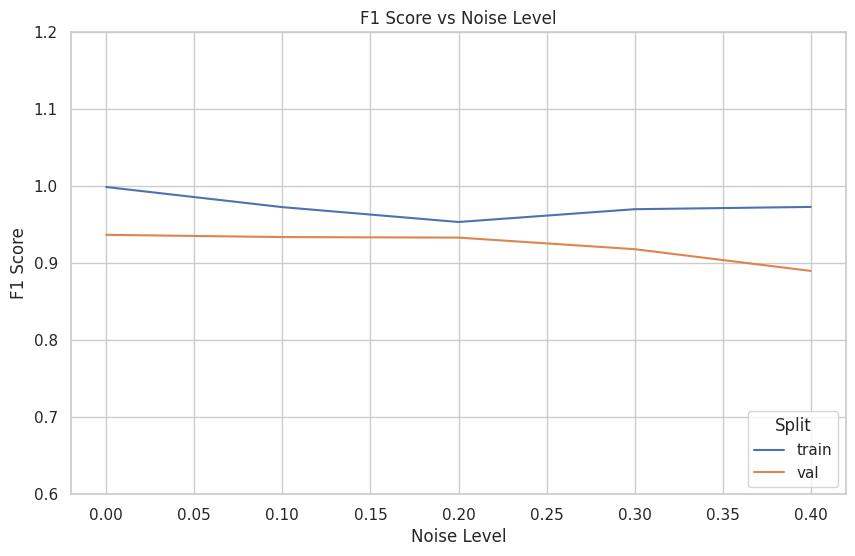

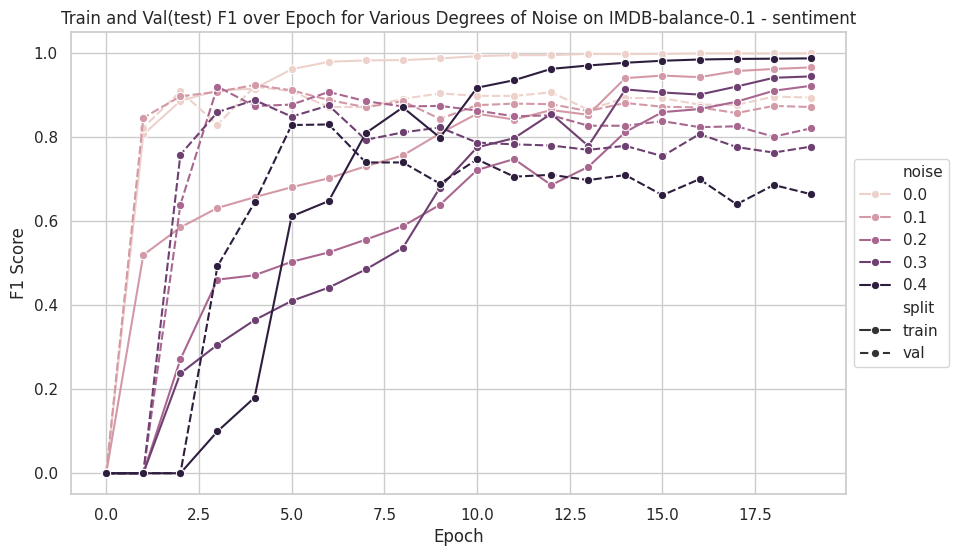

             epochs       f1s
noise split                  
0.0   train      19  0.999500
      val        19  0.920506
0.1   train      19  0.965805
      val        19  0.923971
0.2   train      19  0.922015
      val        19  0.920162
0.3   train      19  0.944403
      val        19  0.888127
0.4   train      19  0.987282
      val        19  0.830043


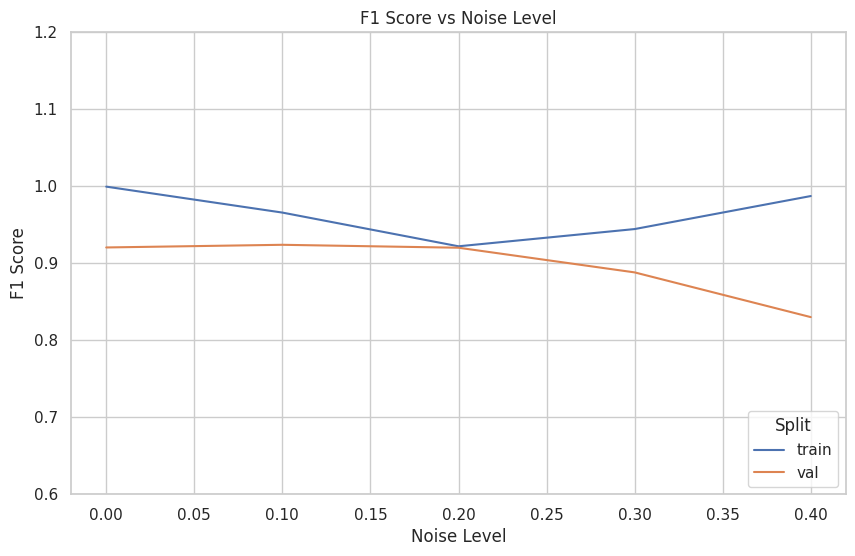

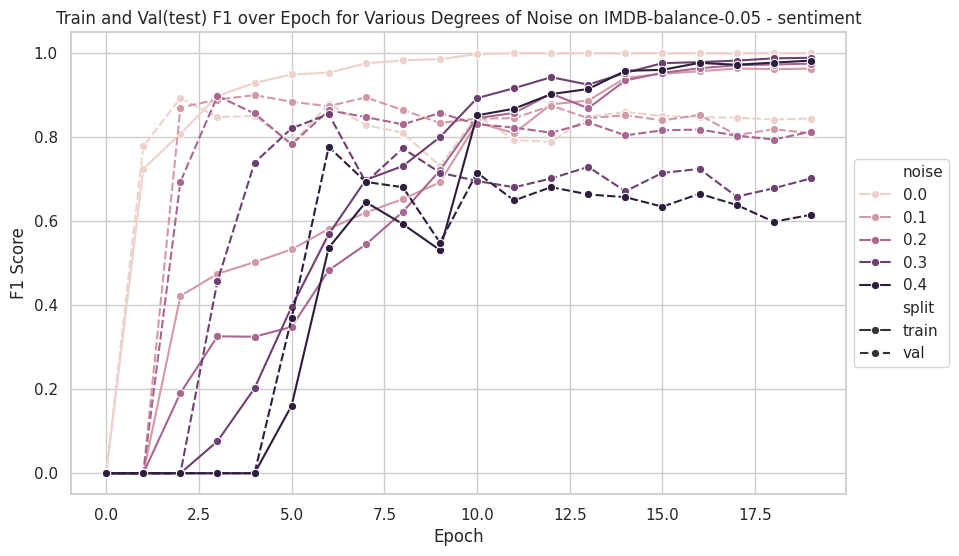

             epochs       f1s
noise split                  
0.0   train      19  1.000000
      val        19  0.893188
0.1   train      19  0.963734
      val        19  0.900285
0.2   train      19  0.975239
      val        19  0.898191
0.3   train      19  0.989244
      val        19  0.855040
0.4   train      19  0.982516
      val        19  0.777030


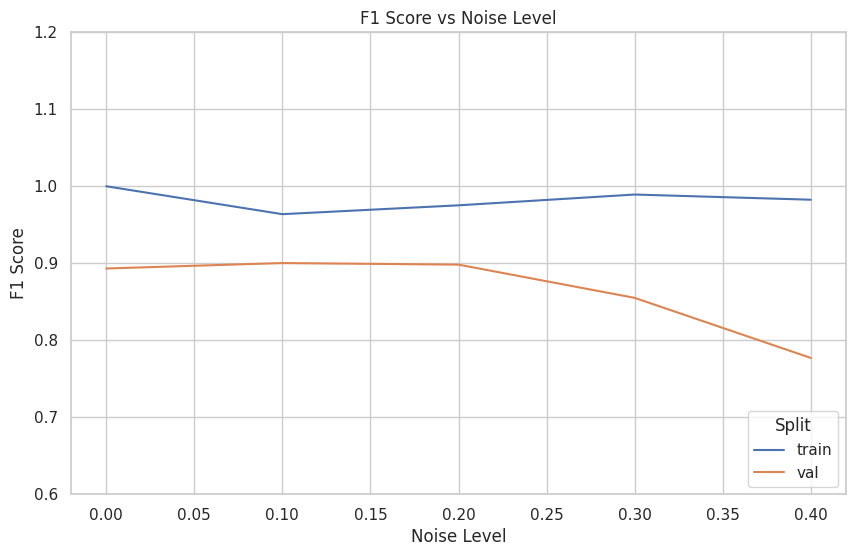

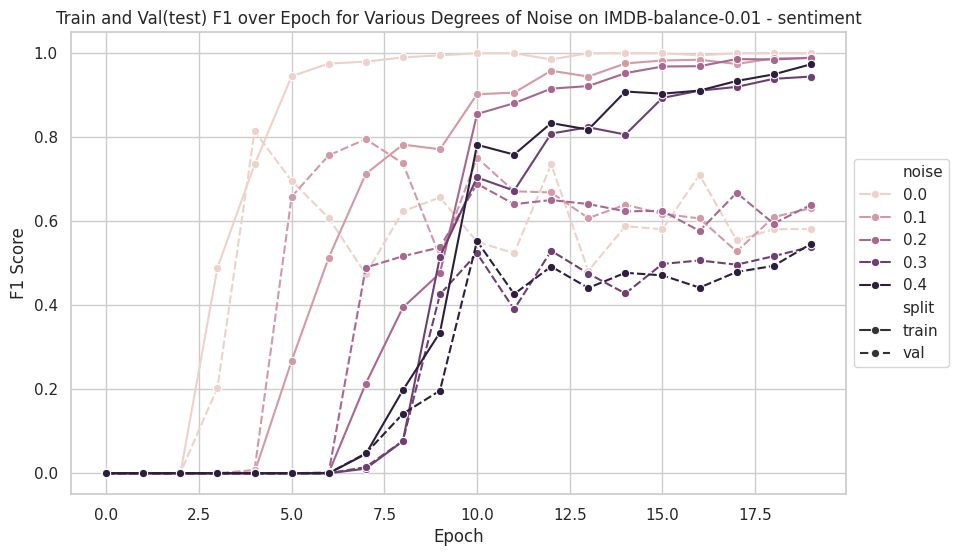

             epochs       f1s
noise split                  
0.0   train      19  1.000000
      val        19  0.813940
0.1   train      19  0.988377
      val        19  0.795404
0.2   train      19  0.989258
      val        19  0.689249
0.3   train      19  0.944389
      val        19  0.539040
0.4   train      19  0.973648
      val        19  0.552660


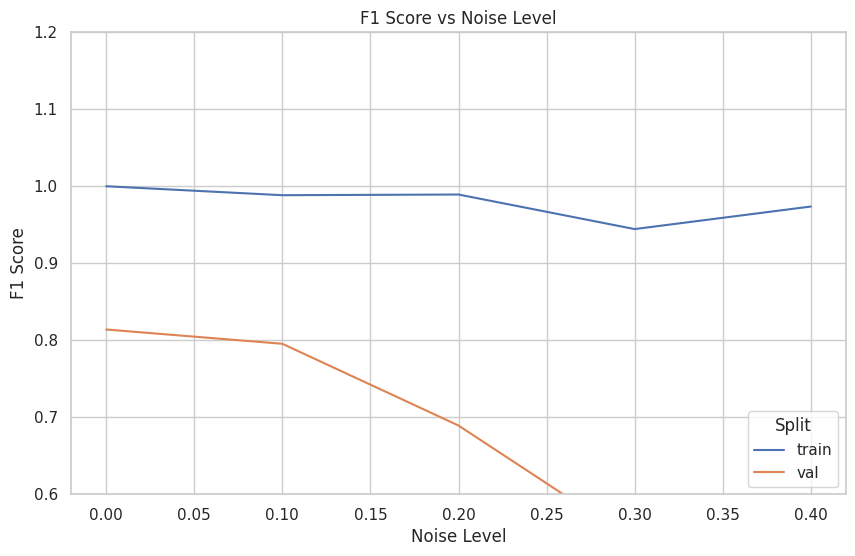

In [81]:
LABEL = "sentiment"
BALANCE = 0.5
EPOCHS = 10
limit = 10000
l2 =0.01
method="lora"
max_dfs = []
for balance in [0.5, 0.4, 0.3,0.2,0.1, 0.05, 0.01]:
    root_dir = f"../experiments/acl-exp5-method-{method}-limit-{limit}-l2-{l2}-balance-{balance}"
    DATASET = f"IMDB-balance-{balance}"
    pred_df = get_pred_df(root_dir)
    f1_df = get_f1_df(pred_df, epochs=EPOCHS)
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='epochs', y='f1s', hue='noise', style="split", data=f1_df, marker='o')

    # Set plot title and labels
    plt.title(f'Train and Val(test) F1 over Epoch for Various Degrees of Noise on {DATASET} - {LABEL}')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')

    # Show the plot
    plt.show()
    max_df = f1_df.groupby([ "noise", "split"]).max()

    print(max_df)

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    max_df["balance"] = balance
    max_dfs.append(max_df.reset_index())
    # You can choose different styles of plots depending on your preference
    sns.lineplot(x=max_df.index.get_level_values('noise'), y='f1s', hue='split', data=max_df.reset_index(), markers=True)
    plt.ylim(0.6, 1.2)
    plt.title('F1 Score vs Noise Level')
    plt.xlabel('Noise Level')
    plt.ylabel('F1 Score')
    plt.legend(title='Split', loc='lower right')


# 

Experimenting with balance = 5, limits 500,400,300,200,100

In [188]:
max_df = pd.concat(max_dfs)


In [189]:
(max_df.balance.unique())

array([0.5 , 0.4 , 0.3 , 0.2 , 0.1 , 0.05, 0.01])

In [190]:
max_df

,noise,split,epochs,f1s,balance
0,0.0,train,19,0.999800,0.50
1,0.0,val,19,0.948661,0.50
2,0.1,train,19,0.990570,0.50
3,0.1,val,19,0.939194,0.50
4,0.2,train,19,0.965083,0.50
...,...,...,...,...,...
5,0.2,val,19,0.689249,0.01
6,0.3,train,19,0.944389,0.01
7,0.3,val,19,0.539040,0.01
8,0.4,train,19,0.973648,0.01


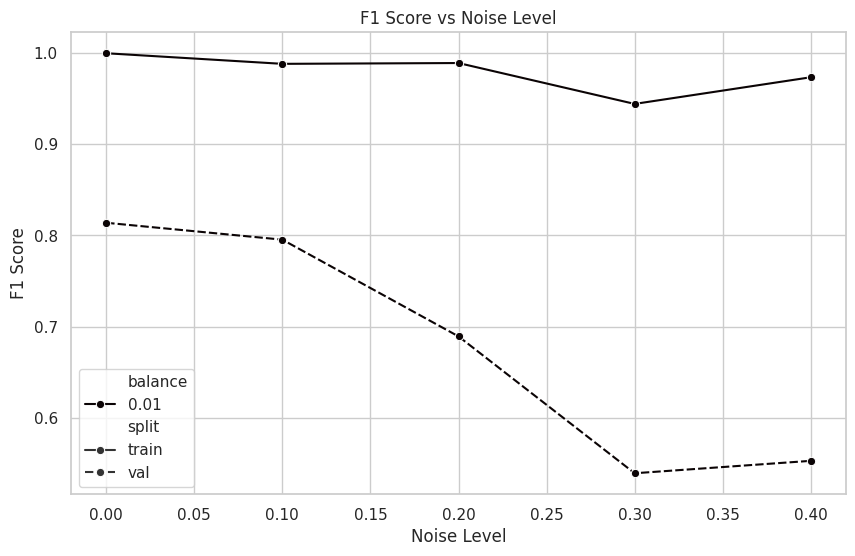

<Figure size 1000x600 with 0 Axes>

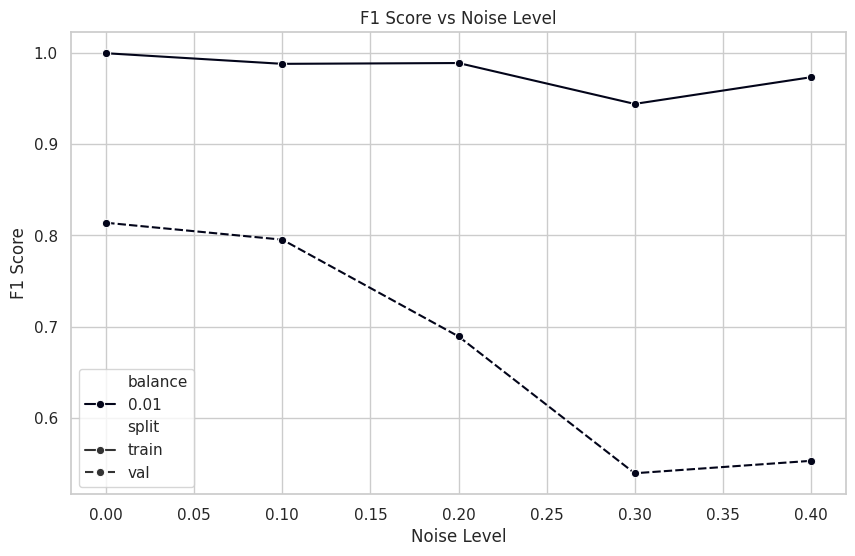

AttributeError: 'DataFrame' object has no attribute 'split'

<Figure size 1000x600 with 0 Axes>

In [82]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# max_dfs.append(max_df.reset_index())
# You can choose different styles of plots depending on your preference
sns.lineplot( palette="mako", x="noise", y='f1s', hue='balance', style="split", data=max_df, marker="o")
# plt.ylim(0.6, 1.2)
plt.title('F1 Score vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('F1 Score')
plt.legend(loc='lower left')
plt.show()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# max_dfs.append(max_df.reset_index())
# You can choose different styles of plots depending on your preference
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# max_dfs.append(max_df.reset_index())
# You can choose different styles of plots depending on your preference
sns.lineplot( palette="rocket", x="noise", y='f1s', hue='balance', style="split", data=max_df, marker="o")
# plt.ylim(0.6, 1.2)
plt.title('F1 Score vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('F1 Score')
# plt.legend([0.5 , 0.4 , 0.3 , 0.2 , 0.1 , 0.05, 0.01], loc='lower left')
plt.show()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))


sns.lineplot(palette="rocket", x="noise", y='f1s', hue='balance', data=max_df[max_df.split=="val"], marker="o", markers=True, linewidth=2.5, linestyle="--")
plt.xlabel('Noise Level')
plt.ylabel('Best F1 Score on Validation')
plt.axvline(x=0.1, color="black", linestyle='--', linewidth=1)
plt.axvline(x=0.2, color="Indigo", linestyle='--', linewidth=1)
plt.axvline(x=0.3, color=sns.color_palette("rocket", 8)[6], linestyle='--', linewidth=1)
plt.legend(title="balance", loc='best')
plt.tight_layout()
plt.savefig('imbalance_robustness.png', dpi=300)  # Set DPI to 300 for high quality


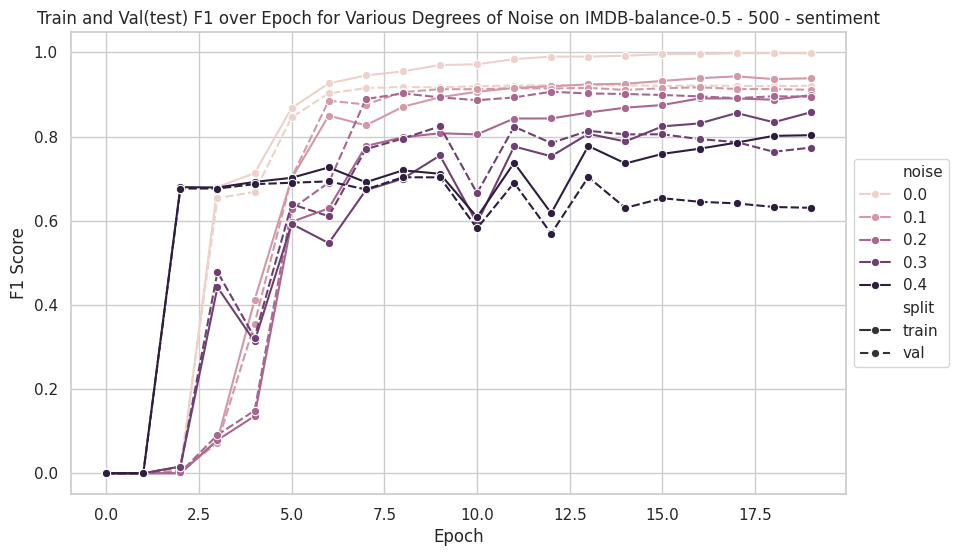

             epochs       f1s
noise split                  
0.0   train      19  0.998004
      val        19  0.922167
0.1   train      19  0.943089
      val        19  0.916988
0.2   train      19  0.898608
      val        19  0.906569
0.3   train      19  0.857724
      val        19  0.824427
0.4   train      19  0.803347
      val        19  0.703704


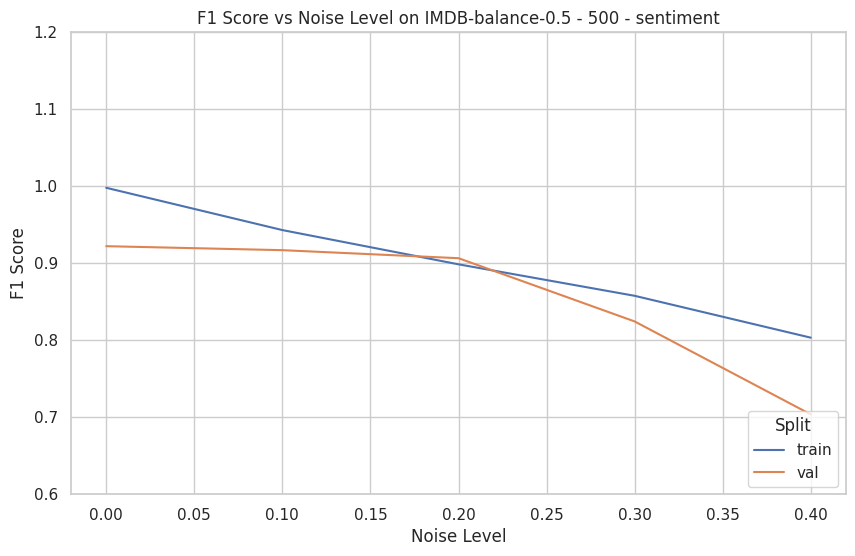

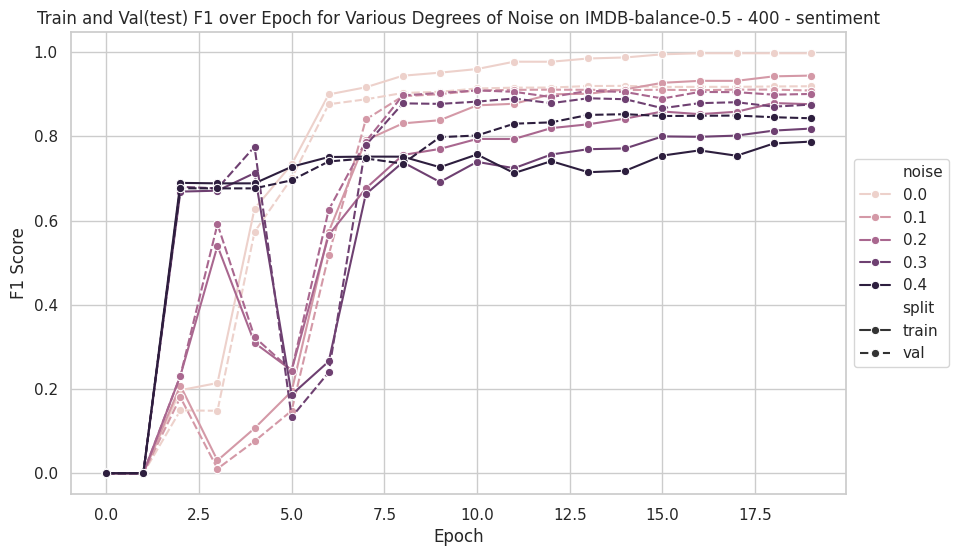

             epochs       f1s
noise split                  
0.0   train      19  0.997506
      val        19  0.920059
0.1   train      19  0.944444
      val        19  0.911116
0.2   train      19  0.879227
      val        19  0.909180
0.3   train      19  0.818605
      val        19  0.890591
0.4   train      19  0.787611
      val        19  0.852747


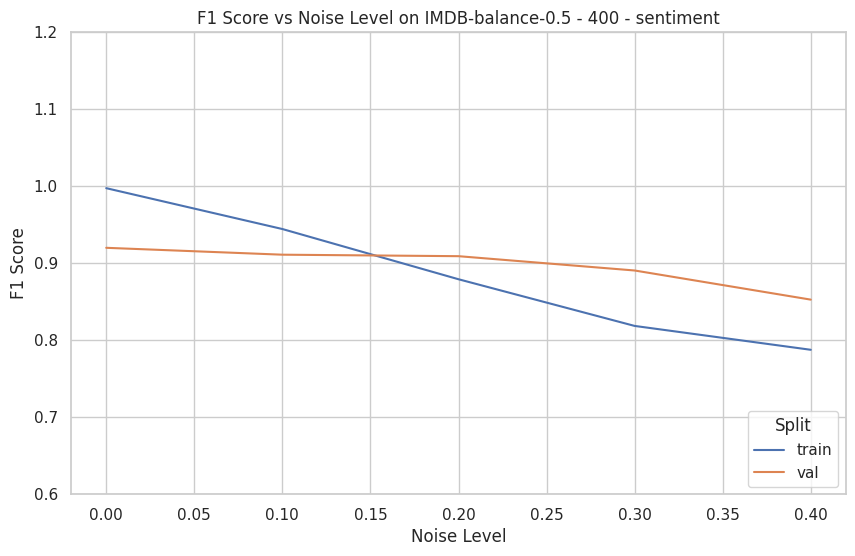

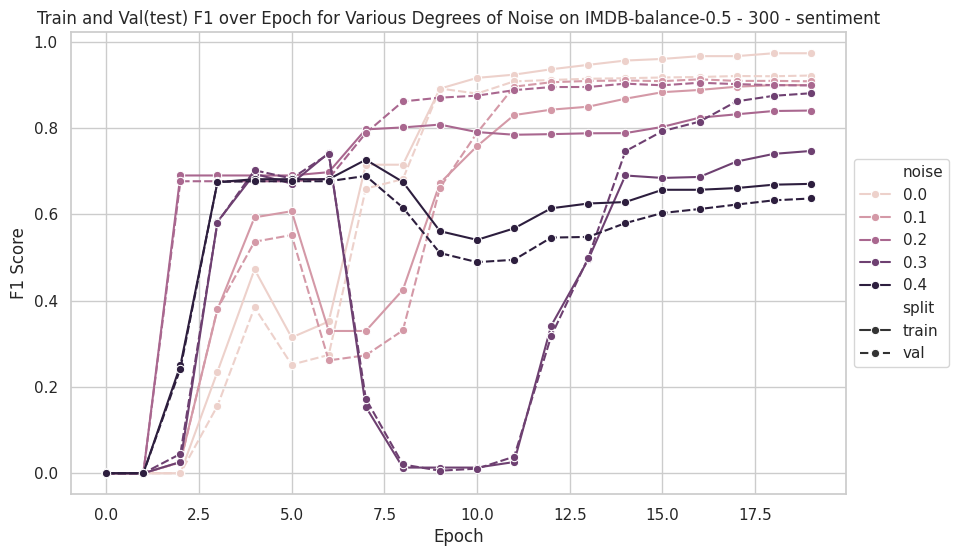

             epochs       f1s
noise split                  
0.0   train      19  0.973154
      val        19  0.921540
0.1   train      19  0.899329
      val        19  0.912795
0.2   train      19  0.840391
      val        19  0.904832
0.3   train      19  0.746753
      val        19  0.880466
0.4   train      19  0.726392
      val        19  0.688905


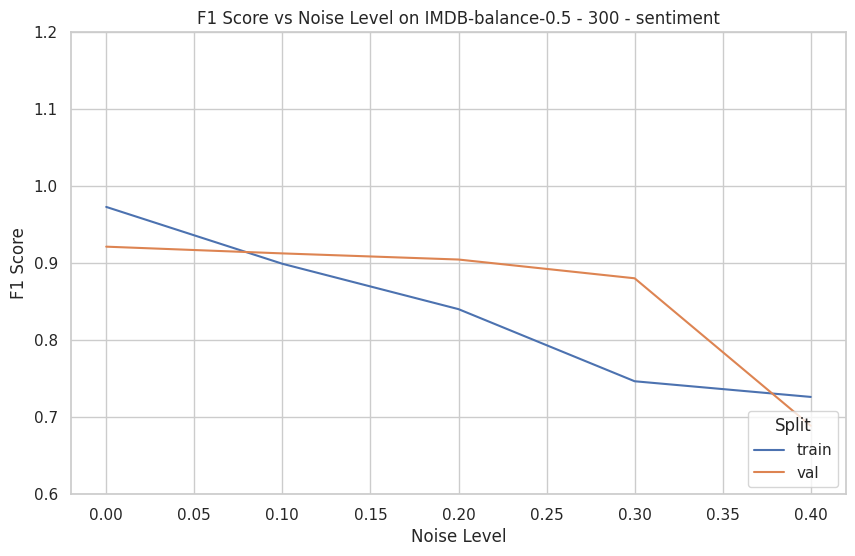

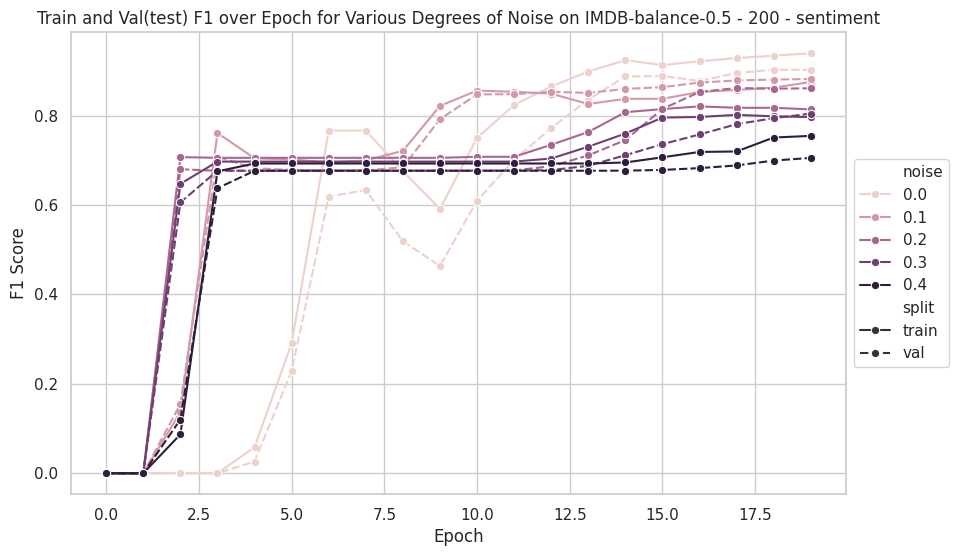

             epochs       f1s
noise split                  
0.0   train      19  0.939394
      val        19  0.902506
0.1   train      19  0.875000
      val        19  0.881752
0.2   train      19  0.820513
      val        19  0.861669
0.3   train      19  0.801619
      val        19  0.804339
0.4   train      19  0.754579
      val        19  0.705306


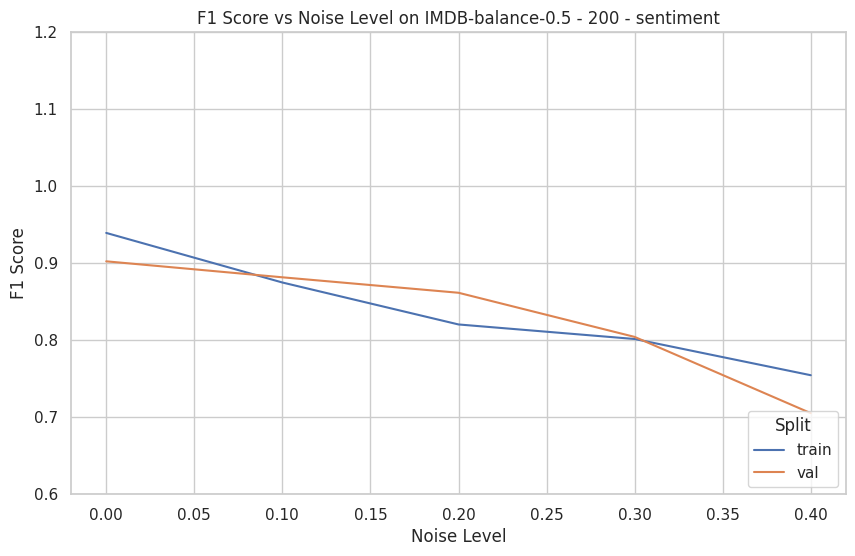

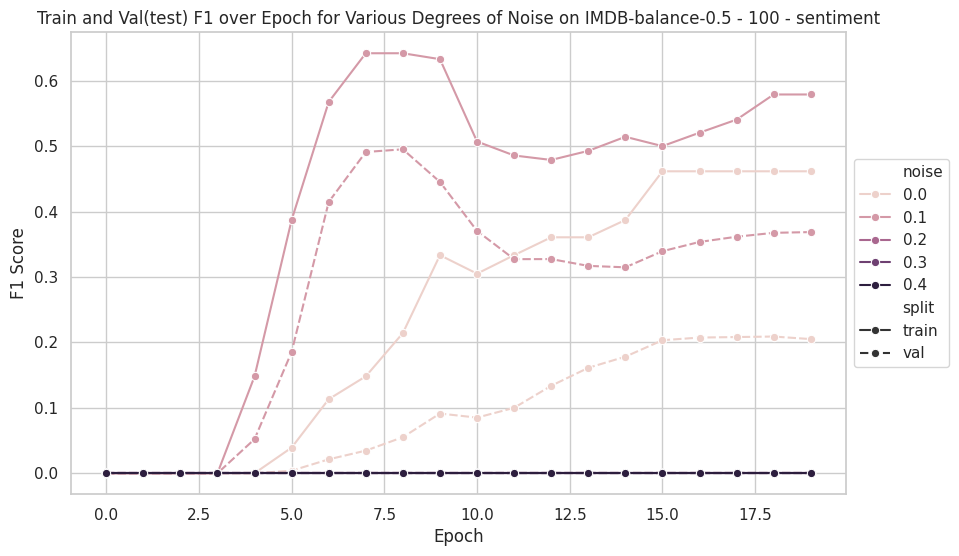

             epochs       f1s
noise split                  
0.0   train      19  0.461538
      val        19  0.208968
0.1   train      19  0.641975
      val        19  0.495155
0.2   train      19  0.000000
      val        19  0.000000
0.3   train      19  0.000000
      val        19  0.000000
0.4   train      19  0.000000
      val        19  0.000000


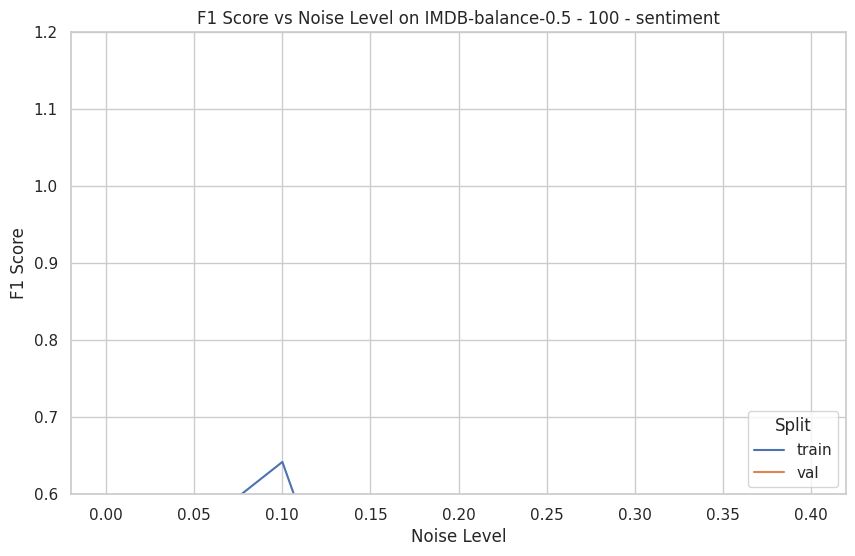

In [5]:
LABEL = "sentiment"
BALANCE = 0.5
EPOCHS = 10
limit = 10000
l2 =0.01
method="lora"
balance = 0.5
for limit in [500, 400, 300, 200, 100]:
    root_dir = f"../experiments/acl-exp6-method-{method}-limit-{limit}-l2-{l2}-balance-{balance}"
    DATASET = f"IMDB-balance-{balance}"
    pred_df = get_pred_df(root_dir)
    f1_df = get_f1_df(pred_df, epochs=EPOCHS)
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='epochs', y='f1s', hue='noise', style="split", data=f1_df, marker='o')

    # Set plot title and labels
    plt.title(f'Train and Val(test) F1 over Epoch for Various Degrees of Noise on {DATASET} - {limit} - {LABEL}')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')

    # Show the plot
    plt.show()
    max_df = f1_df.groupby([ "noise", "split"]).max()

    print(max_df)

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # You can choose different styles of plots depending on your preference
    sns.lineplot(x=max_df.index.get_level_values('noise'), y='f1s', hue='split', data=max_df.reset_index(), markers=True)
    plt.ylim(0.6, 1.2)
    plt.title(f'F1 Score vs Noise Level on {DATASET} - {limit} - {LABEL}')
    plt.xlabel('Noise Level')
    plt.ylabel('F1 Score')
    plt.legend(title='Split', loc='lower right')


# 

is 100/1000 or 60/100 enough?

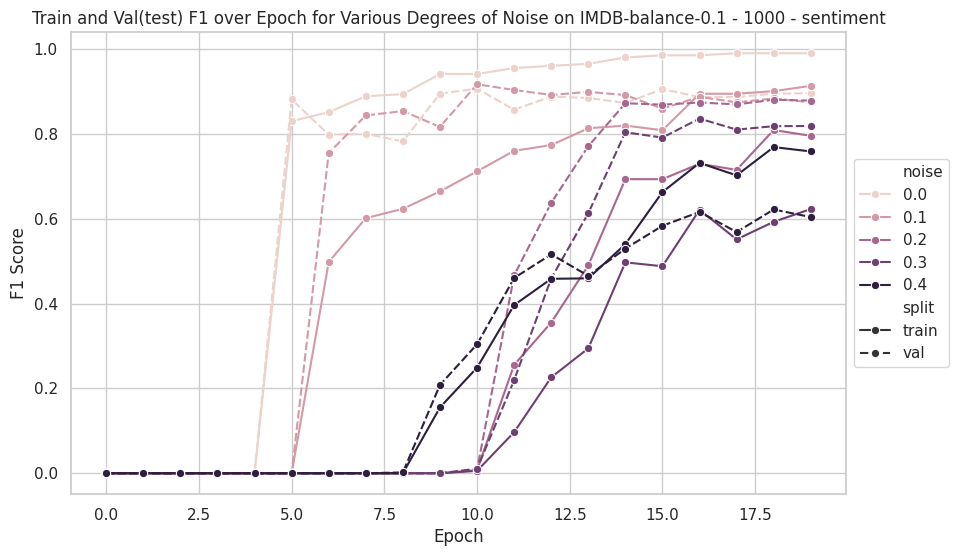

             epochs       f1s
noise split                  
0.0   train      19  0.990099
      val        19  0.906694
0.1   train      19  0.913165
      val        19  0.916955
0.2   train      19  0.809160
      val        19  0.880578
0.3   train      19  0.622776
      val        19  0.836066
0.4   train      19  0.768844
      val        19  0.621800


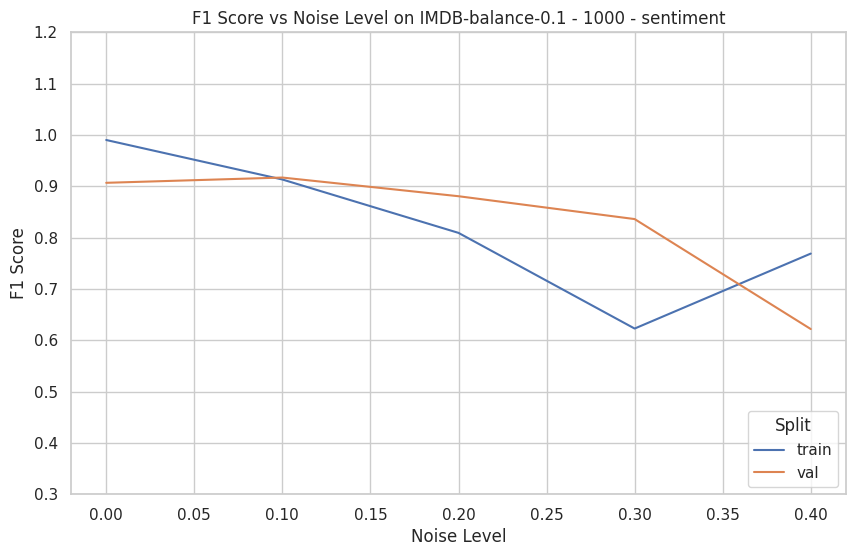

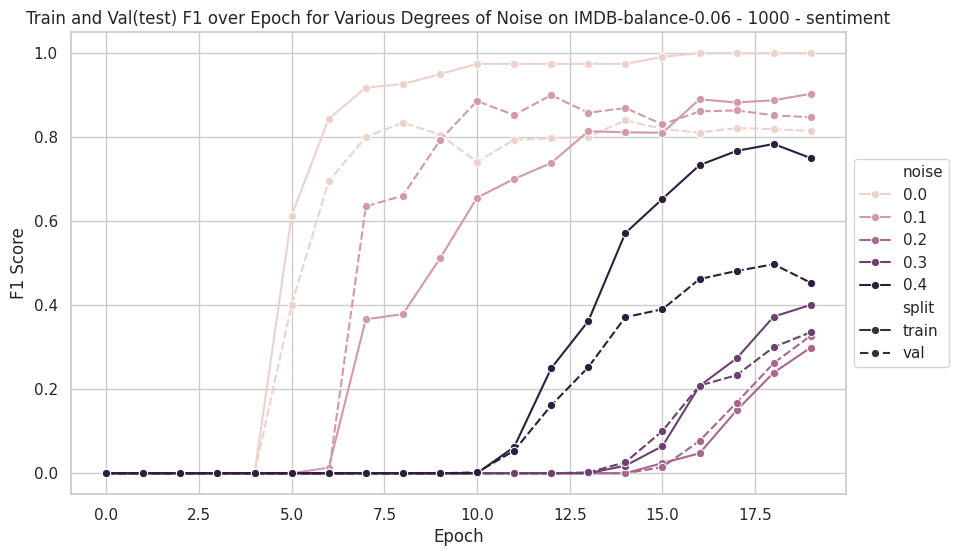

             epochs       f1s
noise split                  
0.0   train      19  1.000000
      val        19  0.840256
0.1   train      19  0.903448
      val        19  0.900295
0.2   train      19  0.299320
      val        19  0.327642
0.3   train      19  0.400901
      val        19  0.335750
0.4   train      19  0.783981
      val        19  0.497605


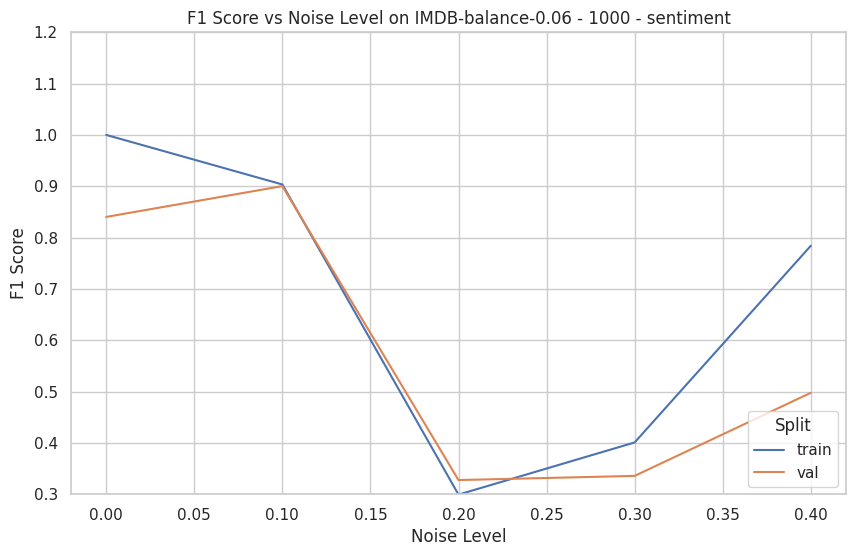

In [7]:
LABEL = "sentiment"
EPOCHS = 10
limit = 1000
l2 =0.01
method="lora"

for balance in [0.1, 0.06]:
    root_dir = f"../experiments/acl-exp6-method-{method}-limit-{limit}-l2-{l2}-balance-{balance}"
    DATASET = f"IMDB-balance-{balance}"
    pred_df = get_pred_df(root_dir)
    f1_df = get_f1_df(pred_df, epochs=EPOCHS)
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='epochs', y='f1s', hue='noise', style="split", data=f1_df, marker='o')

    # Set plot title and labels
    plt.title(f'Train and Val(test) F1 over Epoch for Various Degrees of Noise on {DATASET} - {limit} - {LABEL}')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')

    # Show the plot
    plt.show()
    max_df = f1_df.groupby([ "noise", "split"]).max()

    print(max_df)

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # You can choose different styles of plots depending on your preference
    sns.lineplot(x=max_df.index.get_level_values('noise'), y='f1s', hue='split', data=max_df.reset_index(), markers=True)
    plt.ylim(0.3, 1.2)
    plt.title(f'F1 Score vs Noise Level on {DATASET} - {limit} - {LABEL}')
    plt.xlabel('Noise Level')
    plt.ylabel('F1 Score')
    plt.legend(title='Split', loc='lower right')


# 

what about 60/1000?


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

data = {'epochs': epochs, 'f1s': f1s, "noise":noises, "split":splits}
df = pd.DataFrame(data)
# line_plot(df, "epochs", "f1s", "epochs", "f1s", "F1 through epochs")
df

,epochs,f1s,noise,split
0,0,0.000000,0.0,train
1,0,0.000000,0.0,val
2,0,0.000000,0.1,train
3,0,0.000000,0.1,val
4,0,0.000000,0.2,train
...,...,...,...,...
195,19,0.852114,0.2,val
196,19,0.955461,0.3,train
197,19,0.731521,0.3,val
198,19,0.991925,0.4,train


In [37]:
df.groupby([ "noise", "split"]).max()

epochs       f1s
noise split                  
0.0   train      19  0.999800
      val        19  0.948661
0.1   train      19  0.990570
      val        19  0.939194
0.2   train      19  0.965083
      val        19  0.936379
0.3   train      19  0.955461
      val        19  0.934224
0.4   train      19  0.991925
      val        19  0.892502

<Figure size 1000x600 with 0 Axes>

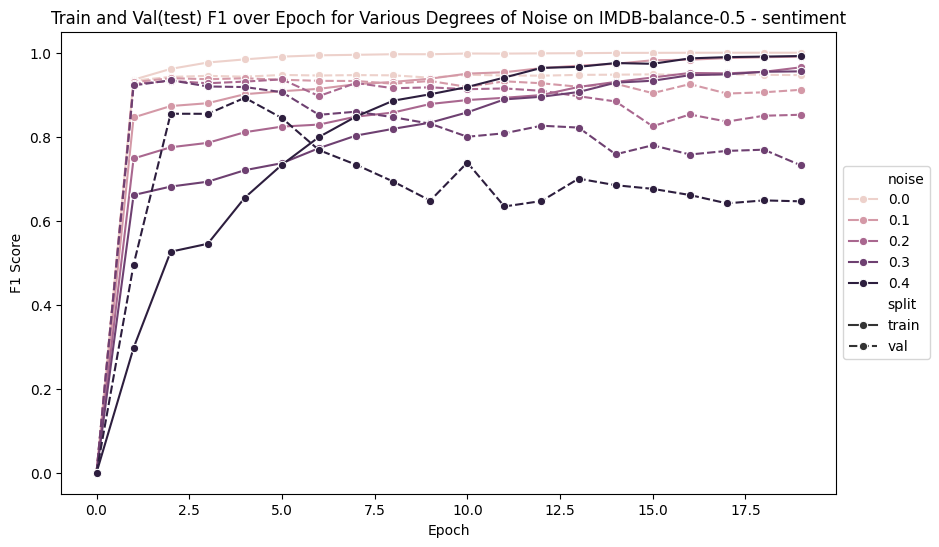

In [38]:

plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
sns.lineplot(x='epochs', y='f1s', hue='noise', style="split", data=df, marker='o')

# Set plot title and labels
plt.title(f'Train and Val(test) F1 over Epoch for Various Degrees of Noise on {DATASET} - {LABEL}')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')

# Show the plot
plt.show()

# Learned

In [41]:
LABEL = "sentiment"
BALANCE = 0.5
EPOCHS = 10
limit = 10000
l2 =0.01
method="lora"
balance = 0.5
root_dir = f"../experiments/acl-exp5-fixed-method-{method}-limit-{limit}-l2-{l2}-balance-{balance}"
pred_df = get_pred_df(root_dir)
pred_df

FILTER_CLEAN = False
FILTER_NOISY = False
if FILTER_CLEAN:
    pred_df = pred_df[pred_df["label_flipped"]==False]

if FILTER_NOISY:
    pred_df = pred_df[pred_df["label_flipped"]==True]

# forgotten_dfs = []


In [42]:
epochs = []
learned_so_far = []
learned_this_epoch = []
forgotten_this_epoch = []
forgotten_so_far = []
splits = []
noise_ratios = []
EPOCHS = 20
for split in ["train", "val"]:
    for noise in [0.0, 0.1, 0.2, 0.3, 0.4]:

        split_df = pred_df[(pred_df["split"] == split) & (pred_df["noise_ratio"] == noise)]
        total_learned = [False]*len(split_df)
        total_forgotten = [False]*len(split_df)

        for i in range(1, EPOCHS+1):
            epochs.append(i)
            splits.append(split)
            noise_ratios.append(noise)
            cur_learned = list(split_df[f"pred_{i}"] == split_df["label"])
            total_learned = [x or y for x, y in zip(total_learned, cur_learned)]
            learned_so_far.append(sum(total_learned))
            if i == 1:
                learned_this_epoch.append(sum(cur_learned))
                forgotten_this_epoch.append(0)
                forgotten_so_far.append(0)
            else:
                learned_this_epoch.append(learned_so_far[-1] - learned_so_far[-2])
                cur_forgotten = list((split_df[f"pred_{i-1}"] == split_df["label"]) & (split_df[f"pred_{i}"] != split_df["label"]))
                forgotten_this_epoch.append(sum(cur_forgotten))
                total_forgotten = [x or y for x, y in zip(total_forgotten, cur_forgotten)]
                forgotten_so_far.append(sum(total_forgotten))
        


# df = pd.DataFrame({'epochs': epochs, 'learned': learned_so_far})
# line_plot(df, "epochs", "learned", "epochs", "total learned so far", "Number of Total Learned (incl forgotten) through epochs")

# df = pd.DataFrame({'epochs': epochs, 'learned_this_epoch': learned_this_epoch})
# line_plot(df, "epochs", "learned_this_epoch", "epochs", "learned_this_epoch", "Number of  newly Learned through epochs")

# df = pd.DataFrame({'epochs': epochs, 'forgotten_this_epoch': forgotten_this_epoch})
# line_plot(df, "epochs", "forgotten_this_epoch", "epochs", "forgotten_this_epoch", "Number of  newly forgotten through epochs")

# print("total learned =", sum(total_learned)/len(pred_df), "\t total_forgotten =", sum(total_forgotten)/len(pred_df))

In [43]:
df = pd.DataFrame({"noise":noise_ratios, 'epochs': epochs, 'forgotten_so_far':forgotten_so_far, 'learned_so_far': learned_so_far, 'learned_this_epoch': learned_this_epoch, 'forgotten_this_epoch': forgotten_this_epoch, "split":splits})
df

,noise,epochs,forgotten_so_far,learned_so_far,learned_this_epoch,forgotten_this_epoch,split
0,0.0,1,0,5342,5342,0,train
1,0.0,2,340,8598,3256,340,train
2,0.0,3,690,9494,896,350,train
3,0.0,4,789,9679,185,128,train
4,0.0,5,804,9697,18,23,train
...,...,...,...,...,...,...,...
195,0.4,16,766,3700,0,43,val
196,0.4,17,770,3723,23,26,val
197,0.4,18,777,3723,0,11,val
198,0.4,19,777,3732,9,7,val


In [44]:
total_train = len(pred_df[(pred_df["split"] == "train") & (pred_df["noise_ratio"] == 0.0)])
total_val = len(pred_df[(pred_df["split"] == "val") & (pred_df["noise_ratio"] == 0.0)])

In [45]:
df

,noise,epochs,forgotten_so_far,learned_so_far,learned_this_epoch,forgotten_this_epoch,split
0,0.0,1,0,5342,5342,0,train
1,0.0,2,340,8598,3256,340,train
2,0.0,3,690,9494,896,350,train
3,0.0,4,789,9679,185,128,train
4,0.0,5,804,9697,18,23,train
...,...,...,...,...,...,...,...
195,0.4,16,766,3700,0,43,val
196,0.4,17,770,3723,23,26,val
197,0.4,18,777,3723,0,11,val
198,0.4,19,777,3732,9,7,val


In [46]:
df[(df["epochs"]==10) & (df["split"] == "train") & (df["noise"]==0.2)]["learned_so_far"].values[0]/total_train

N_fs = []
N_ls = []
noises = []
splits = []
for noise in [0.1, 0.2, 0.3, 0.4]:
    for split in ["train", "val"]:
        N_forgotten = df[(df["epochs"]==EPOCHS) & (df["split"] == split)& (df["noise"]==noise)]["forgotten_so_far"].values[0]
        N_learned = df[(df["epochs"]==EPOCHS) & (df["split"] == split) & (df["noise"]==noise)]["learned_so_far"].values[0]
        print(f"noise {noise} split {split} forgotten {N_forgotten} learned {N_learned} forgotten/learned {N_forgotten/N_learned}")
        N_fs.append(N_forgotten)
        N_ls.append(N_learned)
        noises.append(noise)
        splits.append(split)

learned_df = pd.DataFrame({"noise":noises, "split":splits, "N_forgotten":N_fs, "N_learned":N_ls})


noise 0.1 split train forgotten 1399 learned 9385 forgotten/learned 0.1490676611614278
noise 0.1 split val forgotten 349 learned 3901 forgotten/learned 0.08946423993847731
noise 0.2 split train forgotten 1579 learned 8867 forgotten/learned 0.17807601217999322
noise 0.2 split val forgotten 280 learned 3878 forgotten/learned 0.07220216606498195
noise 0.3 split train forgotten 2248 learned 8464 forgotten/learned 0.2655954631379962
noise 0.3 split val forgotten 387 learned 3864 forgotten/learned 0.10015527950310558
noise 0.4 split train forgotten 3125 learned 7788 forgotten/learned 0.4012583461736004
noise 0.4 split val forgotten 781 learned 3732 forgotten/learned 0.20927116827438372


In [47]:
learned_df["method"]="LoRA"
forgotten_dfs.append(learned_df)

In [48]:
plot_df = pd.concat(forgotten_dfs)


,noise,split,N_forgotten,N_learned,method
0,0.1,train,553,9934,Fine-tuning
1,0.1,val,649,3909,Fine-tuning
2,0.2,train,1199,9792,Fine-tuning
3,0.2,val,1120,3920,Fine-tuning
4,0.3,train,1970,9718,Fine-tuning
5,0.3,val,1653,3931,Fine-tuning
6,0.4,train,2963,9979,Fine-tuning
7,0.4,val,2156,3935,Fine-tuning
0,0.1,train,1399,9385,LoRA
1,0.1,val,349,3901,LoRA


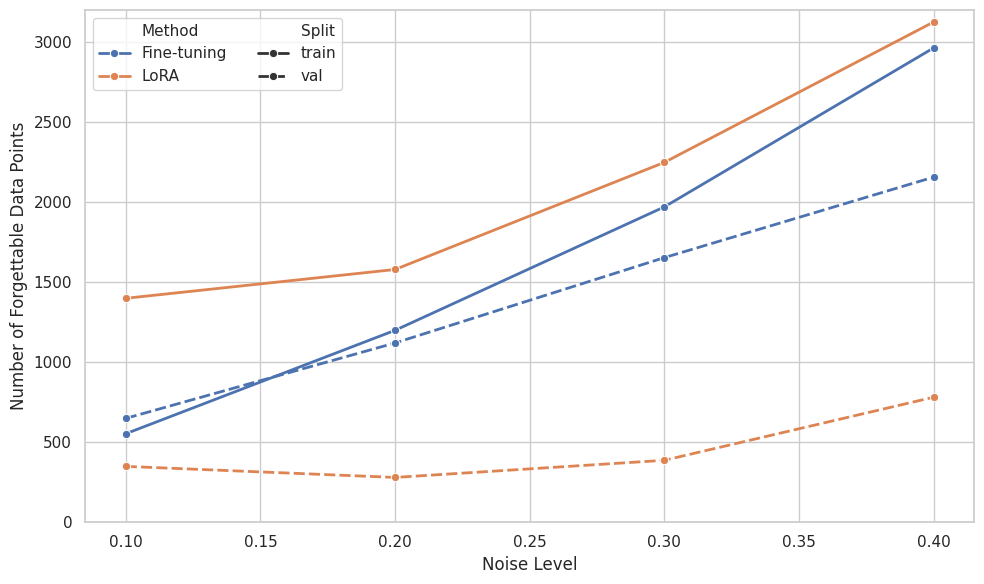

In [80]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='noise', y='N_forgotten', style='split', hue="method", data=plot_df, marker='o', linewidth=2)
plt.ylim(0, 3200)
handles, labels = plt.gca().get_legend_handles_labels()
labels[0]= "Method"
labels[3] = "Split"
plt.legend( handles, labels, loc='upper left', ncol=2)
# for _, row in plot_df.iterrows():
#     plt.text(row['noise'], row['N_forgotten'], str(row['N_forgotten']), ha='center', va='bottom')
plt.ylabel("Number of Forgettable Data Points")
plt.xlabel("Noise Level")
plt.tight_layout()
plt.savefig('forgettable_new.png', dpi=300, bbox_inches='tight')  # Set DPI to 300 for high quality
# plt.title(f"Number of Total forgettable through Epochs on {DATASET} - {LABEL}")


In [62]:
labels

['method', 'Fine-tuning', 'LoRA', 'split', 'train', 'val']

In [35]:
df

,noise,epochs,forgotten_so_far,learned_so_far,learned_this_epoch,forgotten_this_epoch,split
0,0.0,1,0,9673,9673,0,train
1,0.0,2,35,9843,170,35,train
2,0.0,3,58,9895,52,23,train
3,0.0,4,92,9940,45,41,train
4,0.0,5,94,9944,4,3,train
...,...,...,...,...,...,...,...
95,0.4,6,1244,3796,80,412,val
96,0.4,7,1508,3796,0,272,val
97,0.4,8,1534,3804,8,142,val
98,0.4,9,1643,3804,0,213,val


Text(0.5, 1.0, 'Number of Total Learned (incl forgotten) through Epochs on IMDB-balance-0.5 - sentiment')

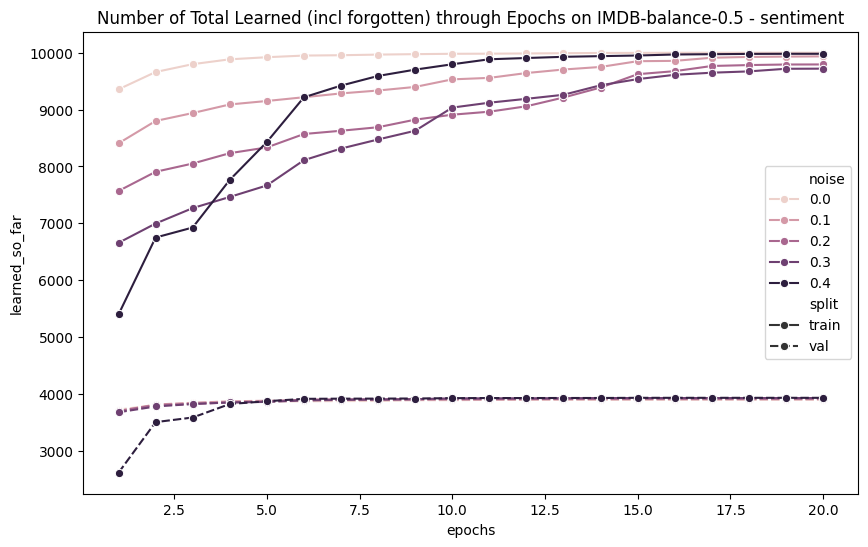

In [31]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="epochs", y="learned_so_far", hue="noise", style="split", marker='o')
plt.title(f"Number of Total Learned (incl forgotten) through Epochs on {DATASET} - {LABEL}")

Text(0.5, 1.0, 'Number of Forgotten Data Points in Each epoch IMDB-balance-0.5 - sentiment')

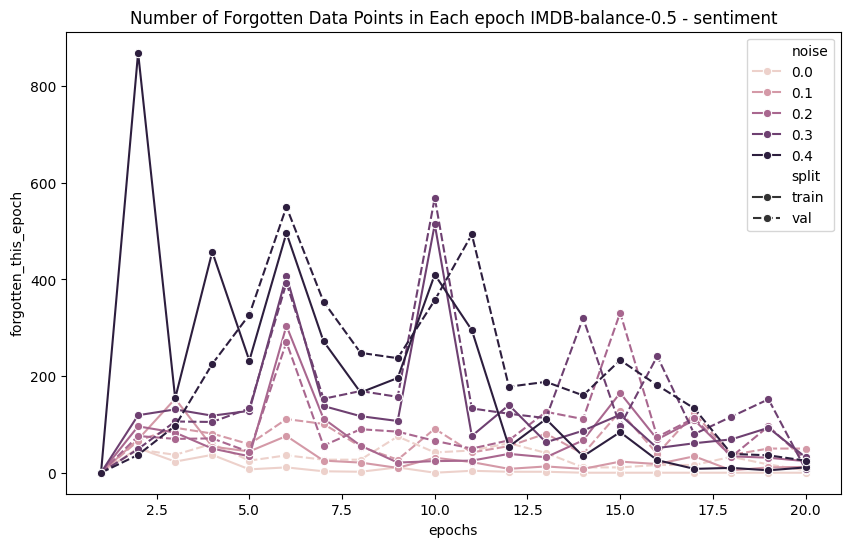

In [34]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="epochs", y="forgotten_this_epoch", hue="noise", style="split", marker='o')
plt.title(f"Number of Forgotten Data Points in Each epoch {DATASET} - {LABEL}")

Text(0.5, 1.0, 'Number of New Data Points Learned in Each epoch')

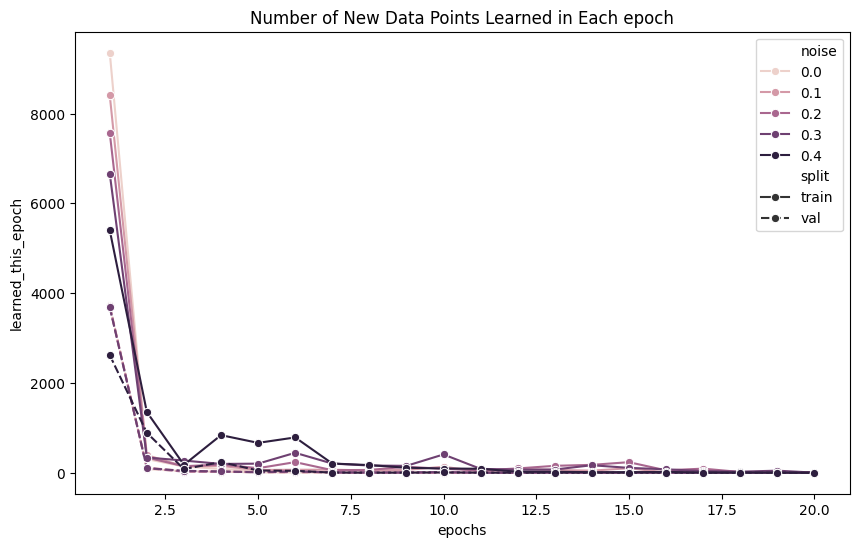

In [35]:
# this counts learning of each data point only once
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="epochs", y="learned_this_epoch", hue="noise", style="split", marker='o')
plt.title("Number of New Data Points Learned in Each epoch")

In [201]:
cur_forgotten

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [202]:
total_learned


[True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,